In [205]:
#imports and settings
import pandas as pd 
pd.set_option('display.expand_frame_repr', False)
import numpy as np
from matplotlib import pyplot as plt 
plt.style.use('fivethirtyeight')

In [206]:
df = pd.read_csv('/Users/Jakub/loan.csv', low_memory = False)

In [207]:
#Returns a random sample of items - 30% so the dataset is easy to work with
df_sample = df.sample(frac = 0.9)
df_sample.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
504782,66066185,70760963,4800.0,4800.0,4800.0,36 months,10.64,156.33,B,B4,...,NaN,NaN,NaN,NaN,NaN,NaN,5900.0,NaN,NaN,NaN
716228,51879737,55309546,30000.0,30000.0,30000.0,60 months,16.55,738.34,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,40700.0,NaN,NaN,NaN


In [208]:
#Analyzing target variable - loan_status
df_sample['loan_status'].value_counts()

Current                                                541564
Fully Paid                                             187017
Charged Off                                             40795
Late (31-120 days)                                      10417
Issued                                                   7551
In Grace Period                                          5645
Late (16-30 days)                                        2108
Does not meet the credit policy. Status:Fully Paid       1765
Default                                                  1087
Does not meet the credit policy. Status:Charged Off       692
Name: loan_status, dtype: int64

In [209]:
#getting rid of loans with statuses we do not care about
#we do not care about current loans 
#explanation of difference between charged off and default https://help.lendingclub.com/hc/en-us/articles/216127747
#we only care about those loans that are either fully paid or are
#very late
#too little examples with "does not meet the credit policy" to care about these...
mask = df_sample['loan_status'].isin(['Fully Paid','Charged Off','Default'])
df_sample = df_sample[mask]
df_sample['loan_status'].value_counts()


Fully Paid     187017
Charged Off     40795
Default          1087
Name: loan_status, dtype: int64

In [210]:
# now we only work with loans that are either fully paid or late > 121 days
# We create target variable with these two possible values. Positive class
# are late loans - we care about these and want to analyze in detail. 

def CreateTarget(status): 
    if status == 'Fully Paid':
        return False
    else:
        return True
    
df_sample['Late_Loan'] = df_sample['loan_status'].map(CreateTarget)
df_sample['Late_Loan'].value_counts()

False    187017
True      41882
Name: Late_Loan, dtype: int64

In [211]:
#drop features with more than 25% missing values
features_missing_series = df_sample.isnull().sum() > len(df_sample)/10
features_missing_series = features_missing_series[features_missing_series == True]
features_missing_list =  features_missing_series.index.tolist()
df_sample = df_sample.drop(features_missing_list,axis =1)

# drop features that have no or little predictive power and original target
df_sample = df_sample.drop(['id','member_id','loan_status','url','zip_code','policy_code','application_type','last_pymnt_d','last_credit_pull_d','verification_status','pymnt_plan','funded_amnt','funded_amnt_inv','sub_grade','out_prncp','out_prncp_inv','total_pymnt_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_amnt','initial_list_status','earliest_cr_line'],axis =1)

#replace missing values with Unknown value or mean when feature is numerical
df_sample['emp_title'].fillna('Unknown',inplace = True)
df_sample['title'].fillna('Unknown',inplace = True)
df_sample['revol_util'].fillna(df_sample['revol_util'].mean(),inplace = True)
df_sample['collections_12_mths_ex_med'].fillna(df_sample['collections_12_mths_ex_med'].mean(),inplace = True)

df_sample.isnull().sum() #there are no missing values left 

loan_amnt                     0
term                          0
int_rate                      0
installment                   0
grade                         0
emp_title                     0
emp_length                    0
home_ownership                0
annual_inc                    0
issue_d                       0
purpose                       0
title                         0
addr_state                    0
dti                           0
delinq_2yrs                   0
inq_last_6mths                0
open_acc                      0
pub_rec                       0
revol_bal                     0
revol_util                    0
total_acc                     0
collections_12_mths_ex_med    0
acc_now_delinq                0
Late_Loan                     0
dtype: int64

In [212]:
#old categorical emp_length feature
df_sample['emp_length'].value_counts()

10+ years    69695
2 years      21330
< 1 year     18893
3 years      18374
5 years      16345
1 year       15197
4 years      14652
6 years      13352
7 years      12721
8 years      10696
n/a           9007
9 years       8637
Name: emp_length, dtype: int64

In [213]:
#new numerical emp_length feature

def EmpLength(year):
    if year == '< 1 year':
        return 0.5
    elif year == 'n/a': #assuming that if not filled out employments was < 1 
        return 0.5
    elif year == '10+ years':
        return 10
    else:
        return float(year.rstrip(' years'))
        
df_sample['emp_length_num'] = df_sample['emp_length'].map(EmpLength)
df_sample = df_sample.drop('emp_length',axis =1 )
df_sample['emp_length_num'].value_counts()

10.0    69695
0.5     27900
2.0     21330
3.0     18374
5.0     16345
1.0     15197
4.0     14652
6.0     13352
7.0     12721
8.0     10696
9.0      8637
Name: emp_length_num, dtype: int64

In [214]:
#transforming to date datatype
df_sample['issue_d'] = pd.to_datetime(df_sample.issue_d)

In [215]:
#datatypes of features 
# object = string ? 
df_sample.dtypes.value_counts()

float64           15
object             7
bool               1
datetime64[ns]     1
dtype: int64

In [216]:
#cleaned and transformed data ready for analysis and ML 
#numerical features - means 
print(df_sample.select_dtypes(include=['float64']).apply(np.mean).apply(str))

# categorical variables 
print(df_sample.select_dtypes(include=['object']).columns)

# target variable - boolean

print(df_sample.select_dtypes(include=['bool']).columns)

loan_amnt                        13570.9357621
int_rate                         13.7779271207
installment                      418.224364021
annual_inc                       72517.5041076
dti                              16.5560590916
delinq_2yrs                      0.25080494017
inq_last_6mths                  0.853979265964
open_acc                         10.9424112818
pub_rec                         0.143591715123
revol_bal                        15170.0179817
revol_util                       54.3219467726
total_acc                        25.0412321592
collections_12_mths_ex_med    0.00686035892349
acc_now_delinq                0.00318044202902
emp_length_num                   5.66482160254
dtype: object
Index([u'term', u'grade', u'emp_title', u'home_ownership', u'purpose',
       u'title', u'addr_state'],
      dtype='object')
Index([u'Late_Loan'], dtype='object')


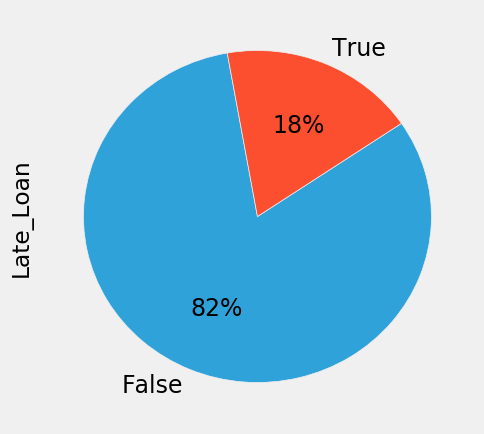

In [217]:
#distribution of our class/targer variable Late_Loan , True if loan is late. 
plt.figure(figsize=(5,5))
df_sample['Late_Loan'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

In [218]:
Amount_By_Year = df_sample.groupby(df_sample['issue_d'].dt.year)['loan_amnt'].mean()
Amount_By_Year = pd.DataFrame(Amount_By_Year)
Amount_By_Year['YoY Change %'] = Amount_By_Year.pct_change()*100
Amount_By_Year.rename(columns = {'loan_amnt':'Average Loan Amount'})

,Average Loan Amount,YoY Change %
issue_d,,
2007,9028.475336,NaN
2008,9269.120801,2.665405
2009,9818.881857,5.931103
2010,10574.662325,7.697215
2011,11628.776785,9.968304
2012,12916.793085,11.076112
2013,14407.292590,11.539238
2014,14246.753673,-1.114289
2015,14489.678743,1.705126


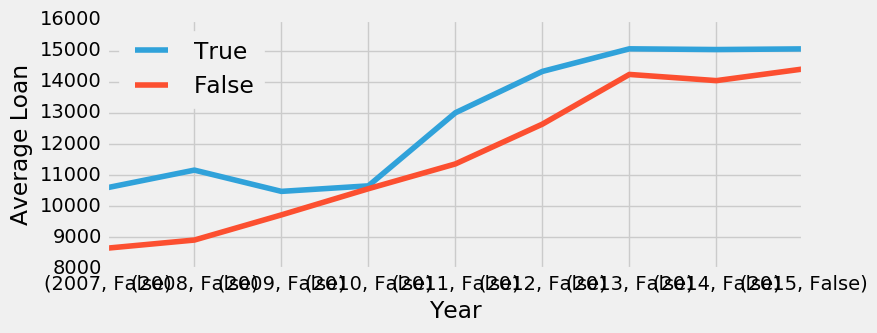

In [219]:
plt.figure(figsize=(8,3))
Amount_By_Year_Status_True = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == True]])['loan_amnt'].mean().plot(kind = 'line', label = 'True')
Amount_By_Year_Status_False = df_sample.groupby([df_sample['issue_d'].dt.year,df_sample['Late_Loan'][df_sample['Late_Loan'] == False]])['loan_amnt'].mean().plot(kind = 'line',label = 'False')
plt.xlabel('Year')
plt.ylabel('Average Loan')
plt.legend(loc='best')
plt.show()
